In [1]:
from google.colab import files

# Prompt the user to upload a file
uploaded = files.upload()


Saving Human+Action+Recognition-20220526T101201Z-001.zip to Human+Action+Recognition-20220526T101201Z-001.zip


In [3]:
import zipfile
import io

# Specify the uploaded zip file name
zip_file_name = 'Human+Action+Recognition-20220526T101201Z-001.zip'

# Unzip the contents
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
pip install thop

In [6]:
# Importing PyTorch modules for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

# Importing pandas for data manipulation
import pandas as pd
import numpy as np
# Importing Python Imaging Library for working with images
from PIL import Image

# Importing operating system utilities for file handling
import os

# Importing scikit-learn modules for preprocessing and evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
# Importing visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt


# Importing additional PIL functionality for displaying images in Tkinter GUI
from PIL import ImageTk

# Importing random module for generating random numbers
import random

from sklearn.model_selection import train_test_split

from tqdm import tqdm

from thop import profile

from torch.utils.tensorboard import SummaryWriter

In [7]:
# List files in the content directory to verify the unzipped folder
!ls /content/

 drive			     Human+Action+Recognition-20220526T101201Z-001.zip
'Human Action Recognition'   sample_data


In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Custom dataset for handling data loading and preprocessing.

        Args:
        - dataframe (pd.DataFrame): DataFrame containing image file names and labels.
        - root_dir (str): Root directory containing the image data.
        - transform (callable, optional): Optional transform to be applied on the image.
        """
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

        # Use LabelEncoder to convert string labels to integers
        self.label_encoder = LabelEncoder()
        self.data['label'] = self.label_encoder.fit_transform(self.data['label'])

    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
        - int: Number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.

        Args:
        - idx (int): Index of the sample.

        Returns:
        - tuple: A tuple containing the image and its corresponding label.
        """
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = int(self.data.iloc[idx, 1])

        # Apply image transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label
    def calculate_mean_std(self):
        pixel_sum = torch.zeros(3)  # Assuming RGB images
        pixel_squared_sum = torch.zeros(3)
        total_samples = len(self.data)

        for idx in tqdm(range(total_samples), desc="Calculating mean and std"):
            img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
            image = Image.open(img_name).convert('RGB')
            image_tensor = transforms.ToTensor()(image)

            pixel_sum += image_tensor.sum(dim=(1, 2))
            pixel_squared_sum += (image_tensor ** 2).sum(dim=(1, 2))

        mean = pixel_sum / total_samples
        std = torch.sqrt(torch.maximum(pixel_squared_sum / total_samples - mean ** 2, torch.tensor(0.0)))
        print("Mean:", mean.tolist())
        print("Std:", std.tolist())

        return mean, std


In [9]:
# Specify the path to the CSV file containing information about the dataset
csv_file = '/content/Human Action Recognition/Training_set.csv'

In [10]:
# Specify the root directory containing the actual image data
root_dir = '/content/Human Action Recognition/train'

In [11]:
# Load data from CSV into a pandas DataFrame
data = pd.read_csv(csv_file)

# Use LabelEncoder to convert string labels to integers
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

In [12]:
# Image Transformation Pipeline

# Define a series of image transformations using torchvision.transforms.Compose
transform = transforms.Compose([
    # Resize the image to a fixed size of (224, 224)
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor()
])


In [13]:
# Create custom dataset for the entire data
dataset = CustomDataset(data, root_dir, transform)
dataset.calculate_mean_std()

Calculating mean and std: 100%|██████████| 12600/12600 [00:18<00:00, 693.41it/s]


Mean: [28625.5546875, 26874.1484375, 25328.525390625]
Std: [0.0, 0.0, 0.0]


(tensor([28625.5547, 26874.1484, 25328.5254]), tensor([0., 0., 0.]))

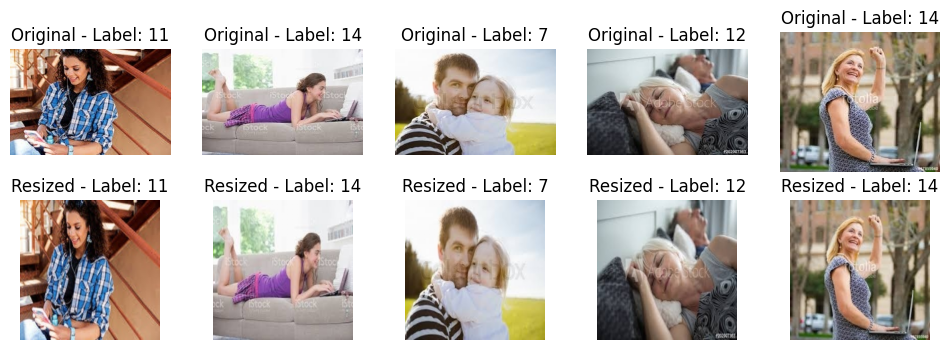

In [14]:
import matplotlib.pyplot as plt

# Select a few random indices from the dataset
sample_indices = [0, 1, 2, 3, 4]

# Create subplots for each sample
fig, axes = plt.subplots(2, len(sample_indices), figsize=(12, 4))

# Plot original images
for i, idx in enumerate(sample_indices):
    img_name = os.path.join(root_dir, data.iloc[idx, 0])
    original_image = Image.open(img_name).convert('RGB')
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f'Original - Label: {data.iloc[idx, 1]}')
    axes[0, i].axis('off')

# Plot resized images
for i, idx in enumerate(sample_indices):
    resized_image, label = dataset[idx]
    axes[1, i].imshow(resized_image.permute(1, 2, 0))  # Permute dimensions for correct display
    axes[1, i].set_title(f'Resized - Label: {label}')
    axes[1, i].axis('off')

plt.show()


In [15]:
val_percentage = 0.2

# Calculate the number of samples for the validation set
val_size = int(val_percentage * len(dataset))
train_size = len(dataset) - val_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [16]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
# Access the label encoder from the original dataset
train_label_encoder = dataset.label_encoder

Label Mapping:
calling -> 0
clapping -> 1
cycling -> 2
dancing -> 3
drinking -> 4
eating -> 5
fighting -> 6
hugging -> 7
laughing -> 8
listening_to_music -> 9
running -> 10
sitting -> 11
sleeping -> 12
texting -> 13
using_laptop -> 14


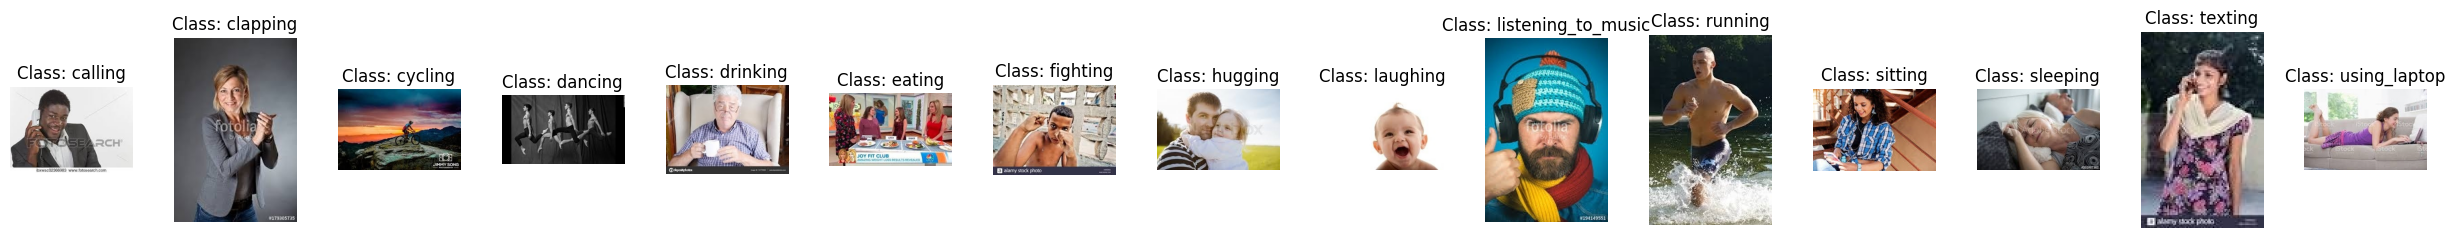

In [18]:
# Print the exact label names along with their mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
for label, encoded_label in label_mapping.items():
    print(f"{label} -> {encoded_label}")

# Load a single sample image for each class
class_sample_images = {}

for encoded_label in train_label_encoder.classes_:
    # Convert encoded label back to the original label name
    class_label = label_encoder.inverse_transform([encoded_label])[0]

    class_samples = dataset.data[dataset.data['label'] == encoded_label]

    # Check if there are samples for the current class
    if not class_samples.empty:
        # Take the first sample for the current class
        image_path = os.path.join(root_dir, class_samples.iloc[0, 0])
        class_sample_images[class_label] = image_path

# Display images if there is at least one class with samples
if class_sample_images:
    # Create subplots only if there are classes with samples
    fig, axes = plt.subplots(1, len(class_sample_images), figsize=(25, 4))

    for i, (class_label, image_path) in enumerate(class_sample_images.items()):
        img = Image.open(image_path).convert('RGB')
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {class_label}')
        axes[i].axis('off')

    plt.tight_layout(pad=3.0)  # Adjust the padding between subplots
    plt.show()
else:
    print("No samples available for any class.")



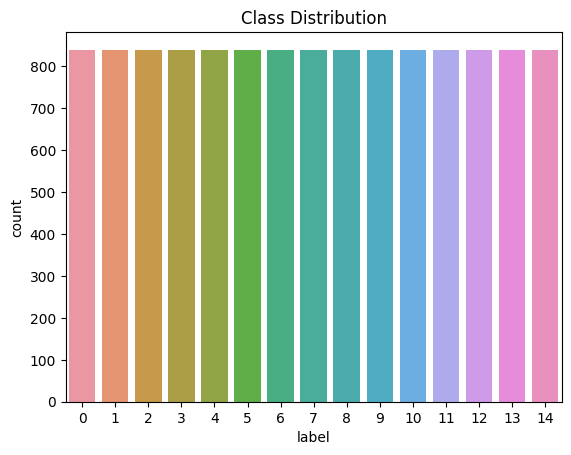

In [19]:
# Utilize Seaborn to create a count plot for visualizing the distribution of classes in the dataset
sns.countplot(x='label', data=dataset.data)  # Use the original dataset for the entire data

# Set the title of the plot
plt.title('Class Distribution')

# Display the plot
plt.show()

In [20]:
import torch

# Check if ROCm is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU:', torch.cuda.get_device_name(0))  # Get the name of the GPU
else:
    device = torch.device('cpu')
    print('ROCm is not available, using CPU')

# Your PyTorch code goes here, and PyTorch will use the available GPU (ROCm) if it's present


GPU: Tesla T4


Final model

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Number of MACs: 4.132752896 G MACs
Number of FLOPs: 8.265505792 G FLOPs


Epoch 1/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1/15: 100%|██████████| 158/158 [01:33<00:00,  1.70it/s]


Epoch [1/15], Loss: 1.4858, Validation Accuracy: 71.03%
Precision: 0.7123, Recall: 0.7103, F1 Score: 0.7069
Confusion Matrix:
 [[116   3   0   3   1   1   0   3   3   5   0   6   1   9   6]
 [  5 107   1   7   7   1   2   8  21   5   0   3   2   4   2]
 [  0   0 170   0   0   0   0   1   0   0   1   1   0   0   0]
 [  1   9   0 110   2   0  14   4   3   2  21   4   2   1   0]
 [  5   3   0   0 131   2   3   1   2   1   1   1   0   6   0]
 [  4   5   0   0  11 147   0   1   0   0   0   0   0   0   1]
 [  0   5   0   7   2   0 129   7   0   2  13   2   4   0   2]
 [  2   5   0   1   4   0   4 121   5   3   1   2  12   1   3]
 [  7   3   0   0   9   0   0   9 133   2   1   0   3   6   0]
 [ 24   0   0   5   5   0   2   6   7 101   5   7   6  15   7]
 [  0   2   3   9   4   0  12   0   0   0 117   0   1   2   0]
 [  9  16   3   2   3   3   7  17   2   3   3  72   8   5  14]
 [  0   0   1   0   1   1   5   1   0   1   0  13 126   2  11]
 [ 20   6   0   0  13   2   1  10   5  11   1   3   4 

Epoch 2/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 2/15: 100%|██████████| 158/158 [01:38<00:00,  1.61it/s]


Epoch [2/15], Loss: 1.1775, Validation Accuracy: 75.95%
Precision: 0.7621, Recall: 0.7595, F1 Score: 0.7591
Confusion Matrix:
 [[117   2   0   3   1   1   0   3   2   8   1   6   1   6   6]
 [  3 121   0   5   8   1   2   7  10   5   1   7   1   1   3]
 [  0   0 168   0   0   0   1   1   0   0   1   2   0   0   0]
 [  0   5   0 127   3   0  15   0   0   5  14   3   1   0   0]
 [  2   4   0   0 133   2   3   1   1   3   1   1   0   5   0]
 [  8   7   0   0   5 147   0   0   0   0   0   0   1   0   1]
 [  1   5   0   9   2   0 134   5   0   1  10   1   4   1   0]
 [  0   3   0   0   3   0   4 133   3   5   0   4   7   1   1]
 [  6   6   0   0   6   1   1   6 133   5   0   1   2   6   0]
 [ 20   0   0   3   4   0   2   1   5 124   2   7   4  15   3]
 [  0   1   1   6   1   0  17   1   0   0 121   1   0   1   0]
 [  7   6   0   1   1   2   7  12   2   5   3  97   7   5  12]
 [  0   0   0   1   0   1   3   0   1   1   0  10 130   2  13]
 [ 20   3   0   0   4   1   2   6   4  19   1   5   5 

Epoch 3/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 3/15: 100%|██████████| 158/158 [01:40<00:00,  1.58it/s]


Epoch [3/15], Loss: 1.1908, Validation Accuracy: 76.87%
Precision: 0.7775, Recall: 0.7687, F1 Score: 0.7677
Confusion Matrix:
 [[ 91   3   0   3   2   1   2   4   1  18   2   7   1   6  16]
 [  1 125   0   8   4   4   2   5   7   8   1   6   1   1   2]
 [  0   0 165   1   0   0   0   1   0   0   3   3   0   0   0]
 [  0   3   0 139   0   0   5   0   0   4  19   2   1   0   0]
 [  1   4   0   0 129   3   3   2   0   7   2   1   0   4   0]
 [  2   3   0   0   7 152   0   2   0   0   0   1   0   0   2]
 [  0   3   0  15   0   1 113   6   0   2  25   1   7   0   0]
 [  0   0   0   0   3   1   2 145   0   1   1   4   6   1   0]
 [  5   7   0   0   8   1   1   8 125  11   1   3   1   2   0]
 [  5   1   0   3   2   0   0   6   2 145   2   6   4  10   4]
 [  0   1   0   5   1   0   3   1   0   0 136   2   0   1   0]
 [  3   6   1   2   1   5   1  14   1   7   6 105   6   1   8]
 [  0   0   0   1   0   1   2   4   0   1   0  10 131   3   9]
 [ 10   5   0   2   5   2   1  12   0  14   2   9   3 

Epoch 4/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 4/15: 100%|██████████| 158/158 [01:40<00:00,  1.57it/s]


Epoch [4/15], Loss: 1.0498, Validation Accuracy: 78.69%
Precision: 0.7896, Recall: 0.7869, F1 Score: 0.7853
Confusion Matrix:
 [[108   4   0   0   4   1   0   3   4  12   1   3   1   9   7]
 [  1 140   0   2   2   2   2   4   7   5   2   5   1   1   1]
 [  1   0 168   1   0   0   0   1   0   0   1   1   0   0   0]
 [  1   2   0 136   1   0   6   1   0   4  20   2   0   0   0]
 [  2   4   0   0 131   3   3   2   0   4   1   1   0   5   0]
 [  2   4   0   0   7 149   0   2   0   0   0   2   0   0   3]
 [  0   3   0  17   3   0 117   4   0   2  16   3   8   0   0]
 [  0   2   0   1   2   0   2 144   1   2   0   3   7   0   0]
 [  4   9   0   1   5   1   1   6 128   6   0   3   6   3   0]
 [  6   2   0   4   1   1   0   1   2 148   2   6   3  10   4]
 [  0   0   1   7   1   0   4   0   1   0 134   1   0   1   0]
 [  3   8   2   0   2   3   2  14   2   4   5 103   3   1  15]
 [  0   0   0   1   0   1   2   1   0   1   0   9 138   3   6]
 [  9   6   0   2   5   2   0   9   4  18   2   5   4 

Epoch 5/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 5/15: 100%|██████████| 158/158 [01:40<00:00,  1.57it/s]


Epoch [5/15], Loss: 1.0455, Validation Accuracy: 79.56%
Precision: 0.7969, Recall: 0.7956, F1 Score: 0.7948
Confusion Matrix:
 [[121   0   0   1   1   1   1   0   3   8   2   3   1   9   6]
 [  3 133   0   5   1   3   2   2  12   5   2   4   0   2   1]
 [  0   0 171   0   0   0   0   0   0   0   1   1   0   0   0]
 [  1   2   0 141   0   0   9   0   1   3  14   2   0   0   0]
 [  5   3   0   0 127   2   4   1   2   5   1   1   0   5   0]
 [  4   4   0   0   2 153   1   0   2   0   0   1   0   0   2]
 [  1   4   0  11   2   0 122   2   0   2  21   1   7   0   0]
 [  1   4   0   0   3   0   4 131   6   2   0   4   8   1   0]
 [  5   6   0   0   4   0   1   2 148   3   0   0   3   1   0]
 [  9   1   0   3   3   0   0   2  10 141   2   5   2  10   2]
 [  0   0   1   8   1   0   7   1   0   0 131   0   0   1   0]
 [  6   5   2   1   1   7   4   9   3   5   3 101   2   6  12]
 [  0   0   1   0   0   1   2   0   2   0   0   8 137   4   7]
 [ 14   4   0   1   4   1   2   1   8  12   1   3   4 

Epoch 6/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 6/15: 100%|██████████| 158/158 [01:41<00:00,  1.56it/s]


Epoch [6/15], Loss: 0.7608, Validation Accuracy: 79.72%
Precision: 0.8026, Recall: 0.7972, F1 Score: 0.7982
Confusion Matrix:
 [[122   3   0   2   1   1   1   1   0   9   1   4   1   5   6]
 [  2 134   0   2   2   2   4   1   7   5   1   8   0   3   4]
 [  0   0 169   0   0   0   0   0   0   1   1   2   0   0   0]
 [  1   2   0 138   1   0   7   3   0   6  11   4   0   0   0]
 [  3   2   0   2 133   2   3   0   1   2   1   2   0   5   0]
 [  5   7   0   1   6 141   0   1   1   0   0   5   0   0   2]
 [  1   2   0  11   2   0 137   1   0   1  10   4   4   0   0]
 [  0   1   0   1   2   0   3 149   0   3   0   4   1   0   0]
 [  8   6   0   0   7   0   1   6 133   5   0   2   3   2   0]
 [ 17   0   0   4   2   0   0   1   4 134   3   8   2  11   4]
 [  0   0   1   6   1   0  13   1   0   0 125   2   0   1   0]
 [  3   3   1   0   1   0   3  13   1   5   1 118   4   2  12]
 [  0   0   0   1   0   1   4   3   1   1   0  12 130   3   6]
 [ 14   3   0   1   4   1   2   8   2   9   2   5   3 

Epoch 7/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 7/15: 100%|██████████| 158/158 [01:40<00:00,  1.57it/s]


Epoch [7/15], Loss: 0.9881, Validation Accuracy: 79.64%
Precision: 0.7987, Recall: 0.7964, F1 Score: 0.7950
Confusion Matrix:
 [[ 98   2   0   3   0   2   1   2   8  10   1   5   1  17   7]
 [  0 141   0   5   0   1   3   2  12   2   0   5   0   2   2]
 [  0   0 170   0   0   0   0   1   0   0   1   1   0   0   0]
 [  0   2   0 142   0   0   8   1   0   3  15   2   0   0   0]
 [  4   8   0   1 116   5   3   2   3   6   1   1   0   6   0]
 [  2   8   0   0   2 152   0   1   1   0   0   1   0   0   2]
 [  0   3   0  11   0   1 133   2   0   3  11   3   6   0   0]
 [  0   5   0   0   2   0   1 147   4   0   0   1   2   1   1]
 [  2   7   0   0   1   0   2   4 149   2   0   2   2   2   0]
 [  6   3   0   3   1   0   0   4  10 135   4   5   1  12   6]
 [  0   0   0   7   1   0   8   0   0   0 132   1   0   1   0]
 [  1  12   1   0   0   2   2  14   3   6   2  98   4   4  18]
 [  1   1   0   1   0   1   1   2   1   0   0   7 139   3   5]
 [  7   9   0   2   5   2   1   5   5   7   1   3   4 

Epoch 8/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 8/15: 100%|██████████| 158/158 [01:40<00:00,  1.57it/s]


Epoch [8/15], Loss: 0.9019, Validation Accuracy: 79.56%
Precision: 0.7991, Recall: 0.7956, F1 Score: 0.7954
Confusion Matrix:
 [[107   1   0   3   2   1   1   1   3  13   2   8   0   7   8]
 [  1 140   0   3   1   2   2   2  11   1   3   5   1   1   2]
 [  0   0 169   0   0   0   0   0   0   1   2   1   0   0   0]
 [  1   5   0 136   0   0   6   1   0   4  16   3   0   0   1]
 [  3   5   0   1 134   3   3   0   1   2   1   1   0   2   0]
 [  3   5   0   0   5 152   0   1   1   0   0   1   0   0   1]
 [  1   4   0  13   1   1 137   2   0   1   9   2   2   0   0]
 [  0   4   0   0   3   1   5 138   0   0   1   6   4   2   0]
 [  6   9   0   0   4   0   1   4 140   4   0   2   2   1   0]
 [ 10   1   0   3   3   0   1   2   5 137   4   9   2   7   6]
 [  0   0   1   5   1   0   8   0   0   0 133   1   0   1   0]
 [  3   7   1   1   1   2   2   8   1   1   2 114   2   3  19]
 [  1   0   0   1   1   1   4   0   0   0   0  15 132   2   5]
 [ 11   4   0   2   9   2   1   3   2  12   2   7   6 

Epoch 9/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 9/15: 100%|██████████| 158/158 [01:44<00:00,  1.51it/s]


Epoch [9/15], Loss: 0.8382, Validation Accuracy: 79.64%
Precision: 0.8014, Recall: 0.7964, F1 Score: 0.7970
Confusion Matrix:
 [[104   3   0   3   1   1   1   1   3  12   1   6   1  16   4]
 [  1 138   0   1   0   3   3   1  11   2   3   5   0   6   1]
 [  0   0 169   0   0   0   0   0   0   0   1   3   0   0   0]
 [  1   3   0 137   1   0  14   1   0   2  10   3   0   1   0]
 [  4   4   0   1 115   5   6   2   0   2   1   1   0  15   0]
 [  1   4   0   0   3 156   1   0   0   0   0   1   0   0   3]
 [  1   4   0   9   1   0 146   1   0   1   4   1   5   0   0]
 [  0   0   0   1   1   0   4 146   0   1   0   3   4   4   0]
 [  5   6   0   0   1   0   3   7 135   5   0   3   1   7   0]
 [  4   2   0   3   0   0   1   1   3 142   3   7   3  18   3]
 [  0   0   1   7   1   0  13   0   0   0 126   1   0   1   0]
 [  3   7   1   1   0   3   5  13   3   3   1 104   3  11   9]
 [  0   0   0   0   0   1   3   3   1   1   0   9 141   1   2]
 [ 12   6   0   1   2   1   3   5   0  12   1   4   3 

Epoch 10/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 10/15: 100%|██████████| 158/158 [01:45<00:00,  1.50it/s]


Epoch [10/15], Loss: 0.8325, Validation Accuracy: 79.17%
Precision: 0.7936, Recall: 0.7917, F1 Score: 0.7909
Confusion Matrix:
 [[101   2   1   4   4   2   1   2   4   9   1   6   0  10  10]
 [  1 135   0   7   4   4   3   2   9   2   2   2   1   0   3]
 [  0   0 169   1   0   0   0   1   0   0   1   1   0   0   0]
 [  1   1   0 144   0   0  12   0   0   1  12   2   0   0   0]
 [  1   2   0   3 136   3   2   0   0   0   1   0   0   8   0]
 [  1   0   0   0   3 160   1   1   0   0   0   0   0   0   3]
 [  0   2   0  14   1   1 144   1   1   1   4   2   2   0   0]
 [  1   4   0   2   3   0   4 132   5   1   1   7   2   2   0]
 [  5  10   0   0   4   0   2   4 140   2   0   1   1   4   0]
 [  9   0   0   4   2   1   0   0   7 133   3   8   1  17   5]
 [  0   0   1  13   1   0  10   0   0   0 123   1   0   1   0]
 [  3   5   1   5   1   6   3   8   2   2   2 109   3   8   9]
 [  1   0   0   2   0   1   4   3   1   3   0  14 125   1   7]
 [ 13   5   0   4   9   1   2   5   2   6   2   5   2

Epoch 11/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 11/15: 100%|██████████| 158/158 [01:44<00:00,  1.51it/s]


Epoch [11/15], Loss: 0.8153, Validation Accuracy: 79.44%
Precision: 0.7974, Recall: 0.7944, F1 Score: 0.7941
Confusion Matrix:
 [[110   3   0   1   1   1   0   4   0  15   2   5   1   8   6]
 [  2 140   0   1   2   2   5   2   9   5   1   5   0   0   1]
 [  0   0 169   0   0   0   0   1   0   1   1   1   0   0   0]
 [  1   6   0 133   0   0  11   2   0   1  16   3   0   0   0]
 [  2   6   0   1 129   3   2   2   1   1   1   0   1   7   0]
 [  5   5   0   0   4 151   0   0   2   0   0   0   0   0   2]
 [  0   3   0  11   1   0 133   4   0   2  10   5   4   0   0]
 [  0   3   0   1   2   0   2 147   0   3   0   2   4   0   0]
 [  5  10   0   0   4   0   3   6 132   6   0   1   3   3   0]
 [  8   0   0   2   1   0   0   1   3 156   3   5   1   6   4]
 [  0   1   1   8   1   0  10   1   0   1 124   2   0   1   0]
 [  4   7   0   0   2   1   3  14   2   6   2 105   5   3  13]
 [  0   1   0   1   0   1   3   5   1   3   0   7 136   2   2]
 [ 15   5   0   0   5   2   2   7   1  16   2   2   4

Epoch 12/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 12/15: 100%|██████████| 158/158 [01:44<00:00,  1.51it/s]


Epoch [12/15], Loss: 0.8423, Validation Accuracy: 80.91%
Precision: 0.8119, Recall: 0.8091, F1 Score: 0.8095
Confusion Matrix:
 [[124   1   0   1   1   1   0   3   0   5   1   4   0  10   6]
 [  2 147   1   1   1   2   2   1   8   2   0   4   0   3   1]
 [  0   0 170   0   0   0   0   0   0   0   1   2   0   0   0]
 [  1   4   0 144   0   0   5   1   0   1  11   4   0   2   0]
 [  5   2   0   2 128   2   3   1   2   1   1   1   1   7   0]
 [  5   6   0   0   6 150   0   0   1   0   0   0   0   0   1]
 [  1   3   0  10   0   0 134   3   1   0  13   3   5   0   0]
 [  1   1   0   0   2   0   2 144   1   0   0   2   7   4   0]
 [  5   8   0   0   3   0   1   2 140   3   0   2   3   6   0]
 [ 11   1   0   3   1   1   0   1   4 139   3   5   1  17   3]
 [  0   1   1   8   1   0   8   0   0   1 128   1   0   1   0]
 [  3   5   0   0   1   2   3  12   2   2   2 110   4   3  18]
 [  0   1   0   2   0   1   3   5   1   0   0   9 131   3   6]
 [ 16   4   0   1   5   2   2   4   1   6   2   4   4

Epoch 13/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 13/15: 100%|██████████| 158/158 [01:45<00:00,  1.50it/s]


Epoch [13/15], Loss: 0.7186, Validation Accuracy: 80.67%
Precision: 0.8096, Recall: 0.8067, F1 Score: 0.8066
Confusion Matrix:
 [[108   3   1   2   2   1   2   2   1   7   1   5   1  14   7]
 [  3 143   1   1   0   4   4   1   8   4   0   4   0   2   0]
 [  0   0 169   0   0   0   1   1   0   0   0   1   1   0   0]
 [  1   3   0 148   0   0  14   2   0   1   3   1   0   0   0]
 [  0   6   0   0 128   6   3   1   1   0   1   2   0   8   0]
 [  3   4   0   0   0 159   1   0   0   0   0   0   0   0   2]
 [  1   4   0   8   1   0 147   6   0   0   1   1   4   0   0]
 [  1   3   1   1   1   0   3 141   1   0   0   4   8   0   0]
 [  2   8   0   1   3   0   1   5 138   4   0   2   4   5   0]
 [  8   1   0   4   2   0   0   2   3 140   2   8   1  16   3]
 [  0   1   2  11   1   0  18   1   0   0 114   1   0   1   0]
 [  3   7   0   1   1   6   3   7   1   2   1 116   4   2  13]
 [  0   1   1   1   0   1   4   1   1   0   0   7 139   2   4]
 [ 11   6   0   3   3   2   2   6   1  10   1   5   3

Epoch 14/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 14/15: 100%|██████████| 158/158 [01:44<00:00,  1.51it/s]


Epoch [14/15], Loss: 0.9590, Validation Accuracy: 80.12%
Precision: 0.8058, Recall: 0.8012, F1 Score: 0.8017
Confusion Matrix:
 [[ 99   1   1   5   4   1   0   3   2  13   1   7   0  14   6]
 [  2 134   1   6   1   2   3   3   8   4   1   9   0   1   0]
 [  0   0 169   0   0   0   1   0   0   0   1   1   1   0   0]
 [  1   2   0 141   0   0  16   3   0   2   8   0   0   0   0]
 [  4   2   0   2 120   4   3   3   1   4   2   2   0   9   0]
 [  4   3   0   0   1 154   2   0   1   0   0   1   0   0   3]
 [  1   3   0  10   0   0 142   4   1   1   6   2   3   0   0]
 [  0   2   0   0   1   0   4 144   2   1   0   5   2   3   0]
 [  5   6   0   1   1   0   1   8 140   3   0   2   3   3   0]
 [  1   0   0   4   0   1   0   2   1 152   2   6   1  17   3]
 [  0   0   1   6   0   0  14   1   0   2 124   1   0   1   0]
 [  2   2   0   1   1   4   4   9   2   1   2 128   3   3   5]
 [  1   0   0   1   0   1   6   1   1   1   0  11 132   1   6]
 [ 13   4   0   4   3   2   2   5   2  14   1   5   3

Epoch 15/15:   0%|          | 0/158 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 15/15: 100%|██████████| 158/158 [01:45<00:00,  1.50it/s]


Epoch [15/15], Loss: 0.9912, Validation Accuracy: 79.80%
Precision: 0.8039, Recall: 0.7980, F1 Score: 0.7992
Confusion Matrix:
 [[116   1   0   0   4   1   0   1   1   8   3   9   1  10   2]
 [  2 137   1   3   2   1   4   3  10   1   2   8   0   1   0]
 [  0   0 171   0   0   0   0   0   0   0   1   1   0   0   0]
 [  1   3   0 136   0   0  10   2   0   3  14   4   0   0   0]
 [  1   4   0   1 133   3   3   0   1   1   2   1   0   6   0]
 [  4   4   0   0   4 153   1   0   2   0   0   0   0   0   1]
 [  0   4   0  11   0   0 136   2   0   1  11   5   3   0   0]
 [  1   3   0   3   1   0   1 131   1   0   0   8  13   2   0]
 [  6   9   0   0   4   0   2   3 134   2   0   4   5   4   0]
 [  7   1   0   5   2   0   1   0   2 139   4   6   2  17   4]
 [  0   1   1   5   1   0   9   1   0   0 130   1   0   1   0]
 [  3   3   0   3   1   2   2   6   1   2   4 127   4   4   5]
 [  0   1   1   1   0   1   4   1   0   0   0  13 133   2   5]
 [ 13   6   0   3   5   2   0   4   2   7   3   6   3

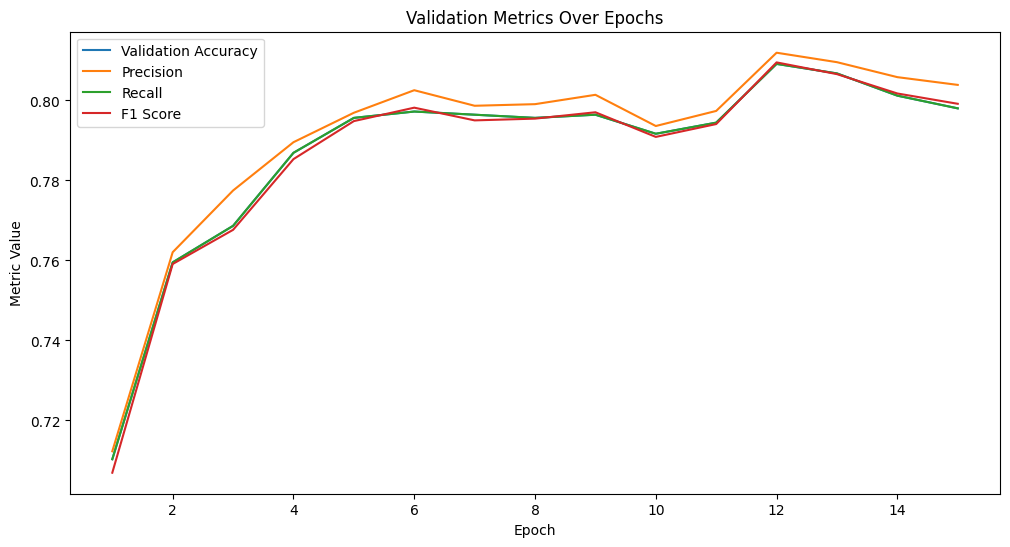

Best Accuracy: 0.00% at Epoch 1


In [24]:

# Define hyperparameters
lr = 0.0001
dropout_rate = 0.5
weight_decay = 0.0001
hidden_size = 512
step_size = 20
num_epochs = 15
save_path = '/content/drive/My Drive/'

# Create a SummaryWriter
writer = SummaryWriter()

# Load pre-trained ResNet18
pretrained_resnet = models.resnet50(weights=models.resnet.ResNet50_Weights.DEFAULT)
pretrained_resnet = nn.Sequential(*list(pretrained_resnet.children())[:-1])

# Define your custom classifier with regularization and batch normalization
custom_classifier = nn.Sequential(
    nn.Linear(2048, hidden_size),
    nn.ReLU(),
    nn.BatchNorm1d(hidden_size),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_size, len(train_dataset.dataset.data['label'].unique())),
    nn.Dropout(dropout_rate)
)

# Combine the pre-trained ResNet and the custom classifier
model = nn.Sequential(
    pretrained_resnet,
    nn.Flatten(),
    custom_classifier
)

# Set the parameters of the pre-trained ResNet to trainable
for param in model[0].parameters():
    param.requires_grad = True

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Learning rate schedule
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

# Count MACs and FLOPs
input_data = torch.randn(1, 3, 224, 224).to(device)
macs, params = profile(model, inputs=(input_data,))
flops = 2 * macs  # Assuming 2 FLOPs per MAC

# Display the results
print(f"Number of MACs: {macs / 1e9} G MACs")
print(f"Number of FLOPs: {flops / 1e9} G FLOPs")

# Initialize variables to track the best accuracy and corresponding epoch
best_accuracy = 0.0
best_epoch = 0
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)

            # Collect predictions and labels for computing metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = correct / total

    # Calculate additional metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

     # Save metrics for visualization
    accuracy_values.append(val_accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    # Print the results
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, '
          f'Validation Accuracy: {val_accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print('Confusion Matrix:\n', conf_matrix)

# Plotting the metrics graph
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy_values, label='Validation Accuracy')
plt.plot(epochs, precision_values, label='Precision')
plt.plot(epochs, recall_values, label='Recall')
plt.plot(epochs, f1_values, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.title('Validation Metrics Over Epochs')
plt.savefig(save_path + 'metrics_graph.png')
plt.show()

# Print the best accuracy and epoch
print(f'Best Accuracy: {best_accuracy * 100:.2f}% at Epoch {best_epoch + 1}')

# Close the SummaryWriter
writer.close()
